# 使用Sybmol模块来构建神经网络

## 符号编程

在[之前的文章](http://www.cnblogs.com/ronny/p/8514194.html)，我们介绍了NDArray模块，它是MXNet中处理数据的核心模块，我们可以使用NDArray完成非常丰富的数学运算。实际上，我们完全可以使用NDArray来定义神经网络，这种方式我们称它为**命令式的编程风格**，它的优点是编写简单直接，方便调试。像下面我们就定义了一个两层的神经网络，它包含了一个全连接层，和一个relu的激活层。

In [50]:
import mxnet as mx
import mxnet.ndarray as nd

def net(X, w, b):
    z = nd.FullyConnected(data=X, weight=w, bias=b, num_hidden=128)
    out = nd.Activation(data=z, act_type='relu')
    return out

既然如此，我们为什么不用NDArray来完成所有事情呢？我们想像一下，如果我们要将我们上面定义的模型保存下来，使用C++ API来实际运行呢，没有非常直接的方法，我们只能根据Python的代码结构来找到对应的c++ api的定义。

MXNet提供了Sybmol API，主要用于符号编程。符号编程不像是命令式编程语句一条一条的执行，我们会首先定义一个计算图来描述整个计算过程，整个计算的输入、输出以及中间结果都是先通过占位符来表示，我们可以编译计算图来生成一个实际的函数，生成的函数可以直接对NDArray进行计算。这样看来，MXNet的Sybmol API有点像Caffe中使用的protobuf格式的网络配置文件，所以我们也很容易将使用Symbol API定义的网络模型保存到磁盘，再通过其他语言的api来读取，方便部署。

符号编程另外一个优势是，我们可以对整个计算图描述的计算过程进行优化，因为在编译计算图的时候，整个计算过程都已经定义完成，我们更加了解每个计算步骤之间的依赖关系，以及一些中间变量的生命周期，这方便我们对操作进行并行化，对一些中间变量使用原地存储来节省内存。

使用NDArray的好处：
1. 简单直观
2. 方便编程，可以整合在一些控制流中（for loop, if-else condition,...）以及一些库相互调用(numpy)。
3. 方便按步调试

使用Symbol的好处：
1. 提供了丰富的运算
2. 方便对计算图进行保存和可视化
3. 通过编译模块可以优化，并行计算与节约存储空间 

## Sybmol中的基本组成

在MXNet的Sybmol API中，我们可以通过`operators`把Symobls和Symbols组成在一起，形成计算图。这些计算图可以是很简单的算术运算，也可以形成一个神经网络。每一种`operator`都接收若干的输入的变量，然后输出一些变量，这些变量我们都用符号来表示。

下面我们代码演示了如果定义一个最简单的加法的计算图：

In [45]:
a = mx.sym.var('a')
b = mx.sym.var('b')
c = a + b
(a, b, c)

(<Symbol a>, <Symbol b>, <Symbol _plus9>)

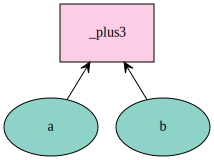

In [7]:
mx.viz.plot_network(c)

从上面我们可以看到，使用`mx.sym.var`来定义一个符号，同时需要指定符号的名称。但是在第三条语句中，我们使用了`+`这个`operator`来连接符号`a`和符号`b`，它的输出为符号`c`，符号c并没有显式的指定一个名称，它的名称是自动生成且惟一的。从输出中，我们可以看出是`_plus0`

上面我们使用了`+`操作符，Sybmol模块定义了丰富的操作符，NDArray支持的运算在Symbol中基本都支持：

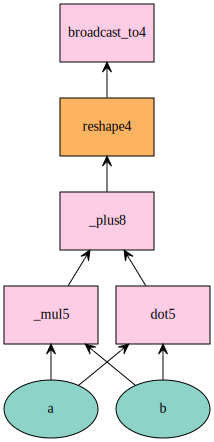

In [13]:
d = a * b
e = mx.sym.dot(a, b)
f = mx.sym.reshape(d + e, shape=(1,4))
g = mx.sym.broadcast_to(f, shape=(2,4))
mx.viz.plot_network(g)

## 参考资料

1. [Symbol - Neural network graphs and auto-differentiation](http://mxnet.incubator.apache.org/tutorials/basic/symbol.html)
2. [Deep Learning Programming Style](https://mxnet.incubator.apache.org/architecture/program_model.html)
3. [Symbol in Picture](https://mxnet.incubator.apache.org/api/python/symbol_in_pictures/symbol_in_pictures.html)

## 更复杂的operator

除了上面介绍的那些基本的操作运算（`*`,`+`,`reshape`）外，Symbol还提供了丰富的神经网络的层的操作，下面的例子显示了，使用Symbol模块的一些高级的operator来构建一个高层的神经网络。

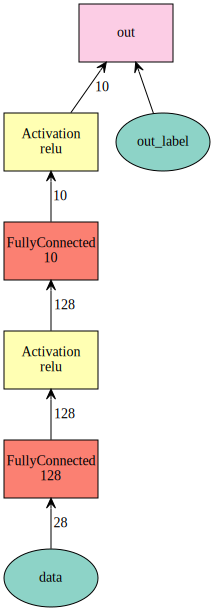

In [16]:
net = mx.sym.var('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.Activation(data=net, name='relu2', act_type='relu')
net = mx.sym.SoftmaxOutput(data=net,name='out')
mx.viz.plot_network(net, shape={'data':(28,28)})

像`mx.sym.FullyConnected`这样的operator接收符号变量作为输入，同时这个操作本身内部是带有参数的，我们通过接口的一些参数来指定。最后的net我们也可以看成是接入了一组参数的一个函数，这个函数需要参数我们可以用下面的方法列出来：

In [17]:
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

## 更复杂的组合

针对深度学习中一些常见的层，MXNet在Symbol模块中都直接做好了优化封装。同时针对于各种不同的需要，我们也可以用Python来定义我们新的operator。

除了像上面那边一层一层向前的组装我们的Sybmol外，我们还可以对多个复杂的Symbol进行组合，形成结构更加复杂的Symbol。

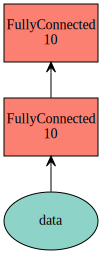

In [30]:
data = mx.sym.var('data')
net1 = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=10)
net2 = mx.sym.var('data')
net2 = mx.sym.FullyConnected(data=net2, name='fc2', num_hidden=10)
# net2就像一个函数一样，接收Symbol net1作为输入
composed = net2(data=net1, name='composed')
mx.viz.plot_network(composed)

## 通过用前缀管理模块来管理Symbol模块参数的名称

当我们要构建一个更大的network时，通常一些Symbol我们希望有一个共同的命名前缀。那么我们就可以使用MXNet的Prefix NameManager来处理：

In [37]:
data = mx.sym.var('data')
net = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=10)
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias']

In [38]:
data = mx.sym.var('data')
with mx.name.Prefix('layer1'):
    net = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=10)
    net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net.list_arguments()

['data',
 'layer1fc1_weight',
 'layer1fc1_bias',
 'layer1fc2_weight',
 'layer1fc2_bias']

## 深度网络的模块化构建方法

当我们在构建大的神经网络结构的时候，比如Google Inception Network，它的层很多，如果我们一层一层的构建那将是一个非常烦索的工作，但是实际上这些网络结构是由非常多结构类似的小网络组合而成的，我们可以模块化的来构建。

在Google Inception network中，其中有一个非常基本的结构就是`卷积`->`BatchNorm`->`Relu`，我们可以把这个部分的构建写成一个小的构建函数：

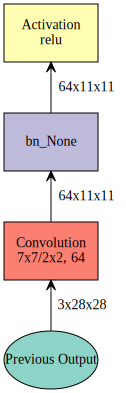

In [39]:
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, 
                              stride=stride, pad=pad, name='conv_{}{}'.format(name, suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn_{}{}'.format(name, suffix))
    act = mx.sym.Activation(data=bn, act_type='relu', name='relu_{}{}'.format(name, suffix))
    return act

prev = mx.sym.Variable(name="Previous Output")
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7,7), stride=(2, 2))
shape = {"Previous Output" : (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape)

接下来我们就可以用ConvFactory来构建一个inception module了，它是Google Inception大的网络建构的基础。

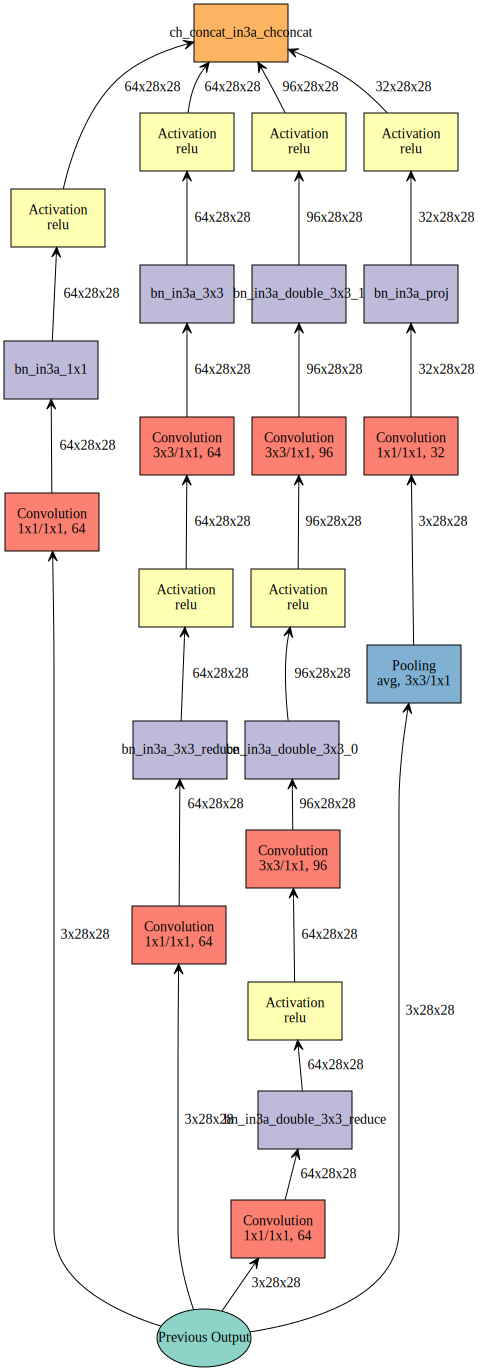

In [40]:
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3,
                      pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1), name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_1' % name))
    # pool + proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.sym.Concat(*[c1x1, c3x3, cd3x3, cproj], name='ch_concat_%s_chconcat' % name)
    return concat
prev = mx.sym.Variable(name="Previous Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
mx.viz.plot_network(symbol=in3a, shape=shape)

## 把多个Symbol组合在一起

上面示例中所有构建的Symbol都是串行向下，有一个输入，一个输出的。但在神经网络中，尤其是设计loss的时候，我们需要将多个loss layer作为输出，这时我们可以使用Symbol模块提供的Group功能，将多个输出组合起来。

['softmax_output', 'regression_output']


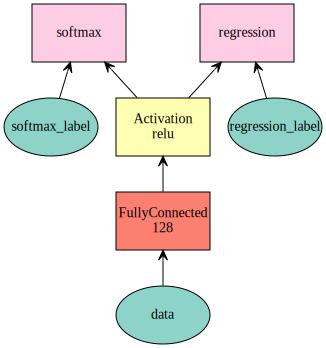

In [43]:
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
print(group.list_outputs())
mx.viz.plot_network(symbol=group)

## Symbol输出shape与type的推断

Symbol只是我们定义好的一个计算图，它本身内部并没有操作任何实际的数据。但我们也可以从这个计算图获取相当多的信息，比如这个网络的输入输出，参数，状态，以及输出的形状和数据类型等。

In [46]:
arg_name = c.list_arguments()  # get the names of the inputs
out_name = c.list_outputs()    # get the names of the outputs
# infers output shape given the shape of input arguments
arg_shape, out_shape, _ = c.infer_shape(a=(2,3), b=(2,3))
# infers output type given the type of input arguments
arg_type, out_type, _ = c.infer_type(a='float32', b='float32')
{'input' : dict(zip(arg_name, arg_shape)),
 'output' : dict(zip(out_name, out_shape))}
{'input' : dict(zip(arg_name, arg_type)),
 'output' : dict(zip(out_name, out_type))}

{'input': {'a': numpy.float32, 'b': numpy.float32},
 'output': {'_plus9_output': numpy.float32}}

## 绑定数据并运行

如果要使得我们之前定义的计算图能够完成计算的功能，我们必须给计算图喂入对应的数据，也就是Symbol的所有自由变量。我们可以使用`bind`方法，它接收一个contxt参数和一个dict参数，dict的元素都是变量名及对应的NDArry组成的一个pair。

In [47]:
ex = c.bind(ctx=mx.cpu(), args={'a' : mx.nd.ones([2,3]),
                                'b' : mx.nd.ones([2,3])})
ex.forward()
print('number of outputs = %d\nthe first output = \n%s' % (
           len(ex.outputs), ex.outputs[0].asnumpy()))

number of outputs = 1
the first output = 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


我们同时可以使用GPU数据进行绑定：

In [48]:
gpu_device=mx.gpu() # Change this to mx.cpu() in absence of GPUs.

ex_gpu = c.bind(ctx=gpu_device, args={'a' : mx.nd.ones([3,4], gpu_device)*2,
                                      'b' : mx.nd.ones([3,4], gpu_device)*3})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()

array([[ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.]], dtype=float32)

对于神经网络来说，一个更加常用的模式就是使用`simple_bind`

## 保存与加载

在我们序列化一个`NDArray`对象时，我们序列化的是面的的tensor数据，我们直接把这些数据以二进制的格式保存到磁盘。但是Symbol是一个计算图，它包含了一连串的操作，我们只是使用最终的输出来表示整个计算图。当我们序列化一个计算图时，我们也是对它的输入Sybmol进行序列化，我们保存为`json`格式，方向阅读与修改。

In [23]:
print(group.tojson())
group.save('symbol-group.json')
group2 = mx.sym.load('symbol-group.json')
group.tojson() == group2.tojson()

{
  "nodes": [
    {
      "op": "null", 
      "name": "data", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "fc1_weight", 
      "attrs": {"num_hidden": "128"}, 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "fc1_bias", 
      "attrs": {"num_hidden": "128"}, 
      "inputs": []
    }, 
    {
      "op": "FullyConnected", 
      "name": "fc1", 
      "attrs": {"num_hidden": "128"}, 
      "inputs": [[0, 0, 0], [1, 0, 0], [2, 0, 0]]
    }, 
    {
      "op": "Activation", 
      "name": "relu1", 
      "attrs": {"act_type": "relu"}, 
      "inputs": [[3, 0, 0]]
    }, 
    {
      "op": "null", 
      "name": "softmax_label", 
      "inputs": []
    }, 
    {
      "op": "SoftmaxOutput", 
      "name": "softmax", 
      "inputs": [[4, 0, 0], [5, 0, 0]]
    }, 
    {
      "op": "null", 
      "name": "regression_label", 
      "inputs": []
    }, 
    {
      "op": "LinearRegressionOutput", 
      "name": "regression", 
      "inputs": [[4, 

True

## 自定义Symbol

在MXNet中，为了更好的性能，大部分的`operators`都是用C++实现的，比如`mx.sym.Convolution`和`mx.sym.Reshape`。MXNet同时允许用户用Python自己写了一些新的operator，这部分的内容可以参考：[How to  create new operator](https://mxnet.incubator.apache.org/faq/new_op.html)

## 类型转换

MXNet在默认的情况下使用`float32`作为所有operator的操作类型。但是为了最大化程序的运行性能，我们可以使用低精度的数据类型。比如：在Nvidia TeslaPascal(P100)上可以使用`FP16`，在GTX Pascal GPUS（GTX 1080）上可以使用`INT8`。

我们可以使用`mx.sym.cast`操作也进行数据类型的转换：

In [24]:
a = mx.sym.Variable('data')
b = mx.sym.cast(data=a, dtype='float16')
arg, out, _ = b.infer_type(data='float32')
print({'input':arg, 'output':out})

c = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
print({'input':arg, 'output':out})

{'input': [<class 'numpy.float32'>], 'output': [<class 'numpy.float16'>]}
{'input': [<class 'numpy.int32'>], 'output': [<class 'numpy.uint8'>]}
